# Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Данные состоят из файлов, полученных из четырех источников:

Таблица contract
+ customerID — ID абонента;
+ BeginDate — дата начала действия договора;
+ EndDate — дата окончания действия договора;
+ Type — тип оплаты: раз в год-два или ежемесячно;
+ PaperlessBilling — электронный расчётный лист;
+ PaymentMethod — тип платежа;
+ MonthlyCharges — расходы за месяц;
+ TotalCharges — общие расходы абонента.

Таблица personal
+ customerID — ID пользователя;
+ gender — пол;
+ SeniorCitizen — является ли абонент пенсионером;
+ Partner — есть ли у абонента супруг или супруга;
+ Dependents — есть ли у абонента дети.

Таблица internet
+ customerID — ID пользователя;
+ InternetService — тип подключения;
+ OnlineSecurity — блокировка опасных сайтов;
+ OnlineBackup — облачное хранилище файлов для резервного копирования данных;
+ DeviceProtection — антивирус;
+ TechSupport — выделенная линия технической поддержки;
+ StreamingTV — стриминговое телевидение;
+ StreamingMovies — каталог фильмов.

Таблица phone
+ customerID — ID пользователя;
+ MultipleLines — подключение телефона к нескольким линиям одновременно.


## Импорт библиотек

In [28]:
!pip install catboost

In [29]:
!pip install phik

In [30]:
!pip install scikit-plot

In [31]:
!pip install shap

In [32]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import shap

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, roc_curve, auc
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier

## Открытие файлов

In [2]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

### Таблица contract

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


array([[<AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

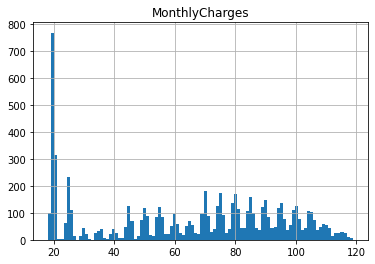

In [6]:
contract.hist(bins=100)

## Таблица personal

In [7]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<AxesSubplot:>

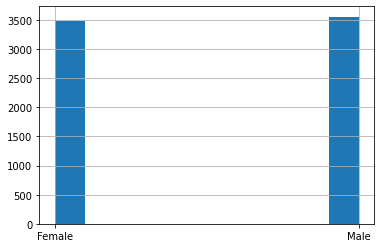

In [10]:
personal['gender'].hist()

<AxesSubplot:>

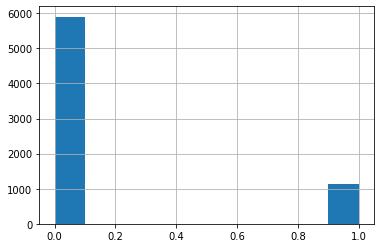

In [11]:
personal['SeniorCitizen'].hist()

<AxesSubplot:>

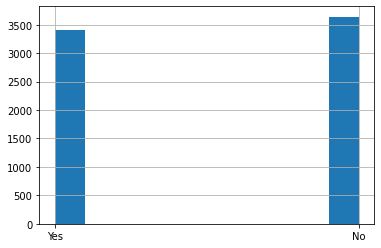

In [12]:
personal['Partner'].hist()

<AxesSubplot:>

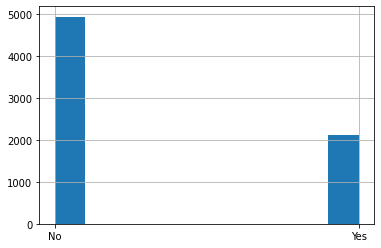

In [13]:
personal['Dependents'].hist()

## Таблица internet

In [14]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<AxesSubplot:>

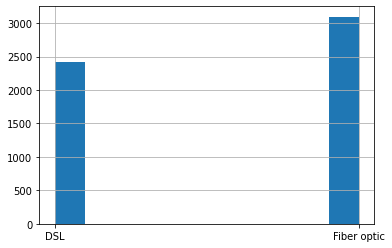

In [17]:
internet['InternetService'].hist()

<AxesSubplot:>

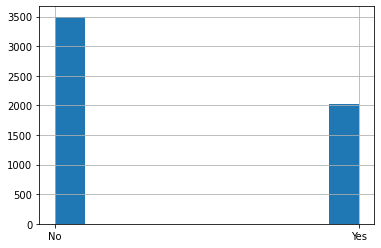

In [18]:
internet['OnlineSecurity'].hist()

<AxesSubplot:>

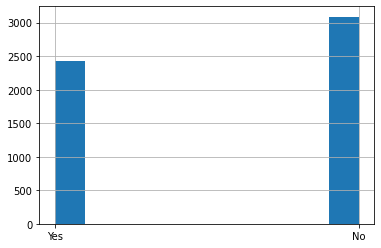

In [19]:
internet['OnlineBackup'].hist()

<AxesSubplot:>

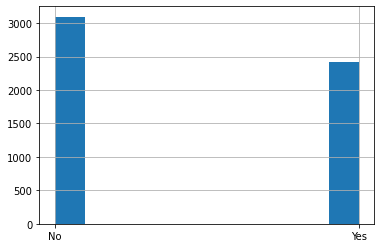

In [20]:
internet['DeviceProtection'].hist()

<AxesSubplot:>

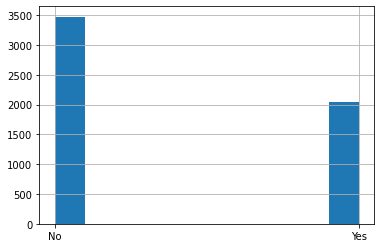

In [21]:
internet['TechSupport'].hist()

<AxesSubplot:>

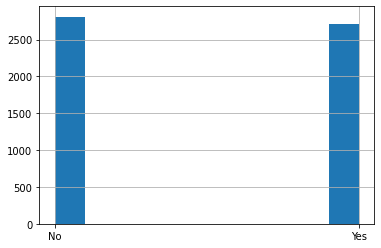

In [22]:
internet['StreamingTV'].hist()

<AxesSubplot:>

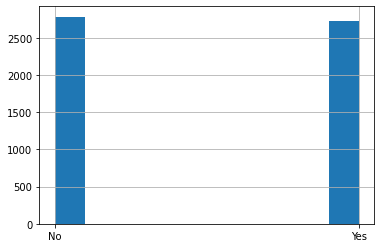

In [23]:
internet['StreamingMovies'].hist()

## Таблица phone

In [24]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [25]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [26]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8512-WIWYV,No
freq,1,3390


<AxesSubplot:>

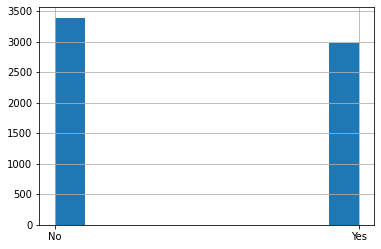

In [27]:
phone['MultipleLines'].hist()

## Предварительные выводы

---

Загружены и проанализированы таблицы с данными: df_contract, df_internet, df_personal, df_phone. Общее число клиентов в выборке составляет 7043 человека, из которых пользователей интернета - 5517, а пользователей телефона - 6361.

---

Таблица contract

+ TotalCharges нужно привести к типу float
+ Из признака EndDate будет сформирован целевой признак, где наличие даты будет соответствовать уходу клиента, а отсутствие даты будет значить, что клиент продолжает сотрудничать с компанией.
+ Признаки BeginDat и EndDate для обучения модели малоэффективны, но из них можно сделать другой признак: количество дней, которые сотрудничал клиент, который может оказаться полезным.

---

Таблица personal

Из этой таблицы можно посмотреть какие клиенты чаще всего пользуются услугами компании. Как видно, что наблюдается практически равное количество среди клиентов женщин и мужчин, а так же среди клиентов в браке и не состоящих в нем. Есть перевес среди клиентов не пенсионеров, а так же клиентов, не имеющих детей.

---

Таблица internet

В таблице представлены не все пользователи, поскольку не все используют услуги одного и того же оператора мобильной связи и домашнего интернета.

---

Таблица phone

Здесь так же представлены не все пользователи.


## Объединение датафреймов

----

Для построения моделей, необходимо объединить все датасеты в один

---

In [33]:
df = pd.merge(contract, personal, on='customerID', how='outer')
df = pd.merge(df, internet, on='customerID', how='outer')
df = pd.merge(df, phone, on='customerID', how='outer')

In [34]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


## Предобработка данных

### Изменение типов данных

---

Cтолбец 'TotalCharges' в датафрейме contract сейчас имеет тип 'object', предположительно, это связано с тем, что в этом столбце есть значения, которые не могут быть автоматически преобразованы в числа. Например, это могут быть строки с символами, отличными от цифр, или пустые строки.

---

In [36]:
# Уберем возможные пробелы
df['TotalCharges'] = df['TotalCharges'].str.strip()

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


### Проверка на пропуски и борьба с ними

---

Так как наши датафреймы изначально имели разное количество строк, так как пользователи могли не использовать услуги интернета, при использовании телефона и наоборот, то при объединении появятся пропуски. Проверим их наличие

---

In [38]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

---

Пропуски в TotalCharges можно заполнить умножив значение траты клиента за месяц MonthlyCharges на количество месяцев, в течение которых он пользуется услугами компании

---

In [39]:
# Преобразование в datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

# Замена 'No' на '2020-02-01' в столбце EndDate
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01')

# Преобразование в datetime
df['EndDate'] = pd.to_datetime(df['EndDate'])

# Вычисление разницы и извлечение количества месяцев
df['MonthDifference'] = (df['EndDate'] - df['BeginDate']).dt.days // 30

# Замена пропусков на произведение MonthlyCharges и MonthDifference
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges']*df['MonthDifference'])

---

Пропуски в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies обусловлены тем, что клиенты используя телефон, не используют услуги интернета. Поэтому пропуски можно заменить на "No"

---

In [40]:
df[['InternetService']] = df[['InternetService']].fillna('No')
df[['OnlineSecurity']] = df[['OnlineSecurity']].fillna('No')
df[['OnlineBackup']] = df[['OnlineBackup']].fillna('No')
df[['DeviceProtection']] = df[['DeviceProtection']].fillna('No')
df[['TechSupport']] = df[['TechSupport']].fillna('No')
df[['StreamingTV']] = df[['StreamingTV']].fillna('No')
df[['StreamingMovies']] = df[['StreamingMovies']].fillna('No')

---

Пропуски в MultipleLines находятся по обратной причине, когда клиент использует интернет, но не использует телефон. Заменим их так же на "No"

---

In [41]:
df[['MultipleLines']] = df[['MultipleLines']].fillna('No')

---

Повторно проверяем на пропуски после всех преобразований

---

In [42]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
MonthDifference     0
dtype: int64

### Проверка на аномалии

---

Так как в основном наши произнаки категориального типа, то аномалии можно посмотреть в MonthlyCharges и TotalCharges

---

In [43]:
df.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,MonthDifference
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.162147,29.596763
std,30.090047,2112.742814,0.368612,22.632985
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,9.000000
50%,70.350000,1343.350000,0.000000,25.000000
75%,89.850000,3236.690000,0.000000,48.000000
max,118.750000,9221.380000,1.000000,77.000000


<AxesSubplot:>

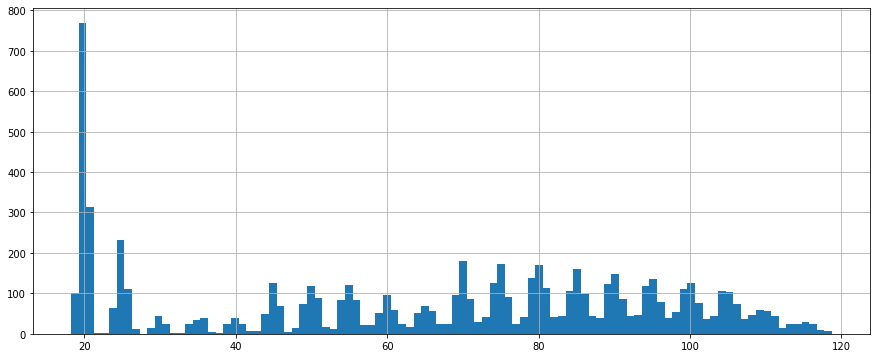

In [44]:
df['MonthlyCharges'].hist(bins=100,figsize=(15,6))

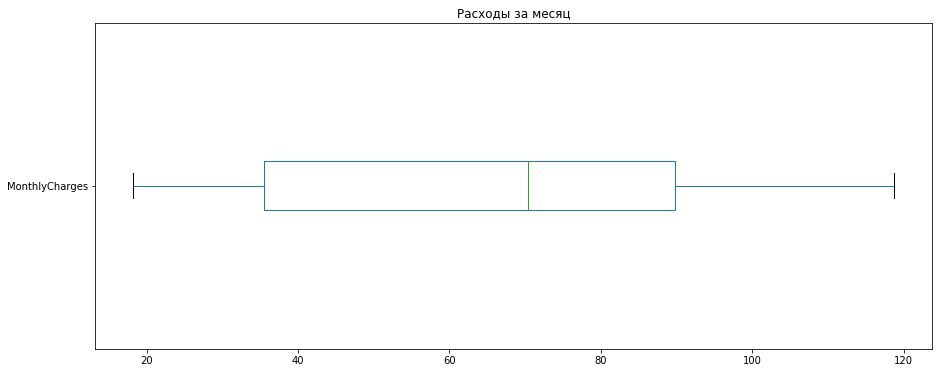

In [45]:
plt.figure(figsize=(15, 6))
df['MonthlyCharges'].plot(kind='box', vert=False)
plt.title('Расходы за месяц')
plt.show()

<AxesSubplot:>

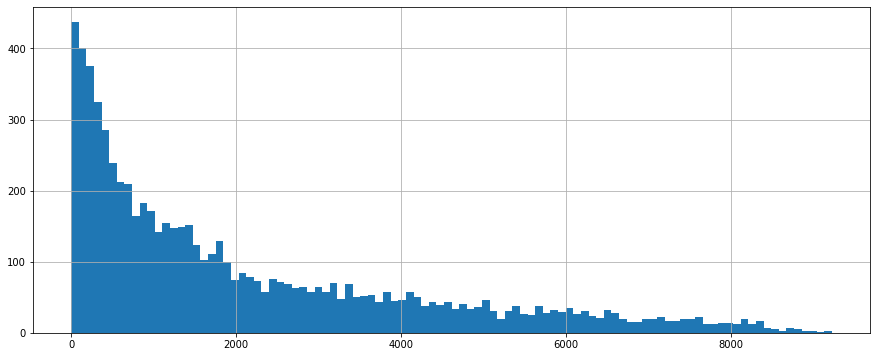

In [46]:
df['TotalCharges'].hist(bins=100,figsize=(15,6))

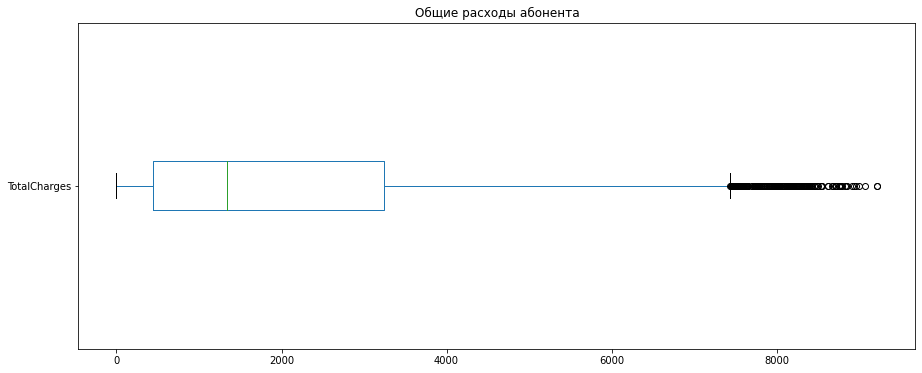

In [47]:
plt.figure(figsize=(15, 6))
df['TotalCharges'].plot(kind='box', vert=False)
plt.title('Общие расходы абонента')
plt.show()

---

В данном случае не корректно говорить о выбросах в TotalCharges, так как аномальные значения - это рассходы, клиентов, которые пользуются дольше остальных и большим количеством услуг

---

### Проверка на дубликаты

In [48]:
df.duplicated().sum()

0

### Создание новых признаков

---

Создадим новый признак Days, который будет указывать количество дней в течение которых клииент пользуется услугами

---

In [49]:
df['Days'] = (df['EndDate'] - df['BeginDate']).dt.days

<div class="alert alert-block alert-success"; style="border-left: 6px solid green">
<b>Комментарий тимлида V2 ✔️</b>
       
Отлиный новый признак, думаю он поможет нашим моделям
    
</div>


In [50]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,MonthDifference,Days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,34,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,4,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,45,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,5,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,Male,0,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,24,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,73,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,...,DSL,Yes,No,No,No,No,No,No,11,337
7041,8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,...,Fiber optic,No,No,No,No,No,No,Yes,7,215


---

Необходимо также внести целевой признак, указывающий, прекратил ли клиент пользоваться услугами. Для создания этого столбца используется анализ признака 'EndDate'. Если указанная дата - '2020-02-01', которая является датой актуальности данной базы данных, то это свидетельствует о том, что клиент продолжал пользоваться услугами до этого периода. Этих клиентов мы помечаем значением 0. Если дата отличается, это означает, что данный клиент прекратил пользоваться услугами, и таких клиентов мы помечаем значением 1.

---

In [51]:
df['Churn'] = 0
df.loc[df['EndDate'] != '2020-02-01', 'Churn'] = 1

In [52]:
phik = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'MonthDifference', 'Days', 'Churn']


The number of unique values of variable customerID is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customerID can be slow.


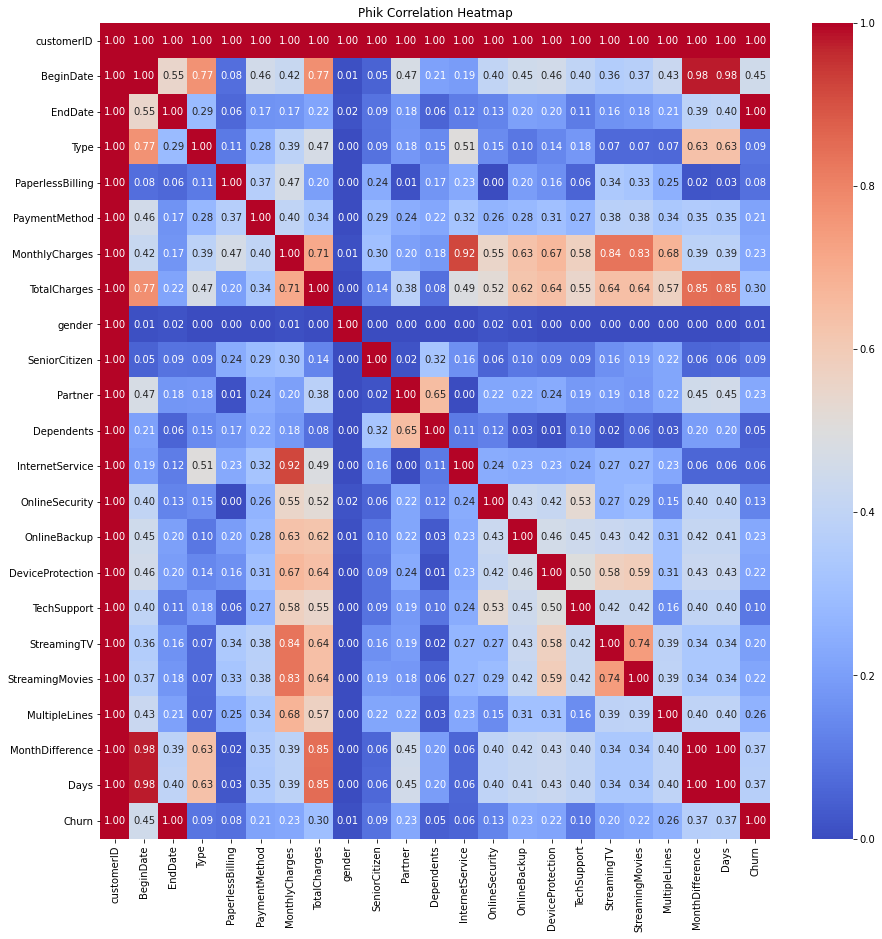

In [53]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Phik Correlation Heatmap")
plt.show()

In [54]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'MonthDifference',
       'Days', 'Churn'],
      dtype='object')

---

Удаляем следующие признаки для предотвращения мультиколлинеарности и избежания бесполезных данных в контексте машинного обучения:

+ BeginDate - предотвращение мультиколлинеарности, так как уже создан признак Days.
+ EndDate - это целевой признак.
+ customerID - наборы символов, бесполезные для машинного обучения.
+ MonthDifference - предотвращение мультиколлинеарности, так как уже есть признак Days.

---

In [55]:
df = df.drop(['BeginDate', 'EndDate', 'MonthDifference', 'customerID'], axis=1)

---

Признаки 'InternetService', 'StreamingTV', 'StreamingMovies' имеют высокую коллинеарность с MonthlyCharges, поэтому в будущем возможно нужно будет удалить эти признаки

---

In [56]:
#df = df.drop(['InternetService', 'StreamingTV', 'StreamingMovies'], axis=1)      

In [57]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days,Churn
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123,0
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,153,0


## Разделение на выборки

---

Зададим фиксированный random_state

---

In [58]:
RANDOM_STATE = 250923

---

Разделим датасет на тренировочную и тестовую выборки

---

In [59]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['Churn'], axis=1), df['Churn'], test_size=0.25, random_state=RANDOM_STATE, stratify=df['Churn']
)

---

Посмотрим правильность разбиения

---

In [60]:
print('Доля тренировочной выборки:', len(x_train) / len(df))
print('Доля тестовой выборки:', len(x_test) / len(df))

Доля тренировочной выборки: 0.7499645037626012
Доля тестовой выборки: 0.25003549623739885


In [61]:
df['Churn'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: Churn, dtype: float64

In [62]:
y_train.value_counts(normalize=True)

0    0.84362
1    0.15638
Name: Churn, dtype: float64

In [63]:
y_test.value_counts(normalize=True)

0    0.843839
1    0.156161
Name: Churn, dtype: float64

---

Видим, что выборка не сбалансирована, но разбиение произведено корректно

---

## Кодирование

In [64]:
x_train_not_cod = x_train
x_test_not_cod = x_test

---

Так как планируется использование линейной модели, а в CatBoost и LightGBM можно использовать встроенные кодировщики, то воспользуемся OHE. Для этого нужно выбрать категориальные признаки

---

In [65]:
x_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days
2028,Two year,No,Mailed check,19.60,294.0,Female,0,No,No,No,No,No,No,No,No,No,No,457
5268,Two year,No,Bank transfer (automatic),86.90,5996.1,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,2102
2445,Month-to-month,No,Mailed check,74.40,2008.8,Female,0,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,No,822
4887,Month-to-month,No,Mailed check,20.45,777.1,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,1157
2118,Month-to-month,Yes,Electronic check,80.15,1869.1,Female,0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,No,671


In [66]:
columns_to_encode = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 
    'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]

encoder = OneHotEncoder(drop='first', sparse=False)

encoder.fit(x_train[columns_to_encode])

x_train_encoded = encoder.transform(x_train[columns_to_encode])
x_test_encoded = encoder.transform(x_test[columns_to_encode])

# Создаем DataFrame с закодированными данными
df_encoded_train = pd.DataFrame(x_train_encoded, columns=encoder.get_feature_names(columns_to_encode))
df_encoded_test = pd.DataFrame(x_test_encoded, columns=encoder.get_feature_names(columns_to_encode))

# Удаляем закодированные категориальные признаки из выборок
x_train = x_train.drop(columns_to_encode, axis=1)
x_test = x_test.drop(columns_to_encode, axis=1)

# Сбрасываем индексы
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

# Объединяем закодированные данные с остальными признаками
x_train = pd.concat([df_encoded_train, x_train], axis=1)
x_test = pd.concat([df_encoded_test, x_test], axis=1)

In [67]:
x_train.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MonthlyCharges,TotalCharges,Days
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.60,294.0,457
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,86.90,5996.1,2102
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,74.40,2008.8,822
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.45,777.1,1157
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,80.15,1869.1,671


In [68]:
x_train.shape

(5282, 22)

In [69]:
x_test.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MonthlyCharges,TotalCharges,Days
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,24.75,849.42,1004
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,80.45,1139.98,396
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.45,354.55,245
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.70,736.78,1036
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,91.05,4370.40,1461


In [70]:
x_test.shape

(1761, 22)

## Стандартизация

---

Для построения линейной модели, нам необходимо масштабировать данные. Проведем стандартизацию необходимых численных признаков:'MonthlyCharges', 'TotalCharges', 'Days'

---

In [71]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Days']

In [72]:
scaler = StandardScaler()
scaler.fit(x_train[numeric])

StandardScaler()

In [73]:
x_train[numeric] = scaler.transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

In [74]:
x_train.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MonthlyCharges,TotalCharges,Days
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.506173,-0.867581,-0.656657
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.731133,1.810672,1.737397
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.315586,-0.062147,-0.125453
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.477916,-0.640671,0.362089
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.506738,-0.127763,-0.345212


In [75]:
x_test.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MonthlyCharges,TotalCharges,Days
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.334967,-0.606703,0.139421
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.516711,-0.470228,-0.745433
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.713309,-0.839141,-0.965191
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.502848,-0.659609,0.185992
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.869095,1.047087,0.804516


## Обучение моделей

### Базовая модель

---

Создадим модель, которая будет всегда предсказывать 0

---

In [76]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class ZeroClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros(X.shape[0])

zero_model = ZeroClassifier()
zero_model.fit(x_train_not_cod, y_train)

naiv_model = roc_auc_score(y_train, zero_model.predict(x_train_not_cod))

print("AUC-ROC Score для базовой модели:", naiv_model)

AUC-ROC Score для базовой модели: 0.5


### Логистическая регрейссия

---

Из линейных моделей используем логистическую регрейссию

---

In [77]:
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

model_logistic = LogisticRegressionCV(Cs=Cs, random_state=RANDOM_STATE, cv=5, scoring='roc_auc')

model_logistic.fit(x_train, y_train)

log_reg = roc_auc_score(y_train, model_logistic.predict_proba(x_train)[:, 1])

In [78]:
print('Лучшее значение параметра:', model_logistic.C_[0])
print('Лучшее значение ROC-AUC:', log_reg)

Лучшее значение параметра: 1.0
Лучшее значение ROC-AUC: 0.7733637699366634


### CatBoost

---

Задаем список столбцов для кодирования

---

In [79]:
cat_features = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'gender','Partner', 
    'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

---

Обучение модели на кросс-валидации с подбором лучших параметров

---

In [81]:
x_train_not_cod[cat_features] = x_train_not_cod[cat_features].astype(str)

catboost_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=1000)
catboost_param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'depth': [2, 4, 8]
}

catboost_grid_search = GridSearchCV(catboost_model, catboost_param_grid, scoring='roc_auc', cv=5)
catboost_grid_search.fit(x_train_not_cod, y_train, cat_features=cat_features)
best_catboost_model = catboost_grid_search.best_estimator_


0:	learn: 0.6857938	total: 50.2ms	remaining: 50.1s
999:	learn: 0.3212794	total: 2.27s	remaining: 0us
0:	learn: 0.6854105	total: 2.74ms	remaining: 2.73s
999:	learn: 0.3212817	total: 2.33s	remaining: 0us
0:	learn: 0.6867917	total: 2.75ms	remaining: 2.75s
999:	learn: 0.3155227	total: 2.34s	remaining: 0us
0:	learn: 0.6857940	total: 2.8ms	remaining: 2.8s
999:	learn: 0.3219026	total: 2.2s	remaining: 0us
0:	learn: 0.6866794	total: 2.53ms	remaining: 2.53s
999:	learn: 0.3140092	total: 2.24s	remaining: 0us
0:	learn: 0.6246363	total: 2.67ms	remaining: 2.67s
999:	learn: 0.2009282	total: 2.44s	remaining: 0us
0:	learn: 0.6213631	total: 2.9ms	remaining: 2.89s
999:	learn: 0.1990675	total: 2.38s	remaining: 0us
0:	learn: 0.6333626	total: 2.54ms	remaining: 2.54s
999:	learn: 0.2025189	total: 2.37s	remaining: 0us
0:	learn: 0.6245617	total: 2.66ms	remaining: 2.66s
999:	learn: 0.1948264	total: 2.42s	remaining: 0us
0:	learn: 0.6323844	total: 2.62ms	remaining: 2.62s
999:	learn: 0.1958285	total: 2.37s	remaining

In [82]:
print("Лучшие параметры для CatBoostClassifier:")
print(catboost_grid_search.best_params_)
print("Лучший AUC-ROC Score для CatBoostClassifier:", catboost_grid_search.best_score_)

Лучшие параметры для CatBoostClassifier:
{'depth': 2, 'learning_rate': 1}
Лучший AUC-ROC Score для CatBoostClassifier: 0.9263146470141483


### LightGBM

---

Список столбцов аналогичен для кодирования со списком модели catboost

---

In [83]:
# Преобразование категориальных признаков с использованием Label Encoding
le = LabelEncoder()
x_train_not_cod[cat_features] = x_train_not_cod[cat_features].apply(le.fit_transform)

lgbm_model = LGBMClassifier(random_state=RANDOM_STATE, verbose=1)

# Определение сетки параметров для поиска
lgbm_param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [2, 4, 7]

lgbm_grid_search = GridSearchCV(lgbm_model, lgbm_param_grid, scoring='roc_auc', cv=5)

lgbm_grid_search.fit(x_train_not_cod, y_train)
best_lgbm_model = lgbm_grid_search.best_estimator_

[LightGBM] [Info] Number of positive: 661, number of negative: 3564
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156450 -> initscore=-1.684885
[LightGBM] [Info] Start training from score -1.684885
[LightGBM] [Info] Number of positive: 660, number of negative: 3565
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 18
[LightGBM] [Info] [bin

In [84]:
print("Лучшие параметры для LightGBM:")
print(lgbm_grid_search.best_params_)
print("Лучший AUC-ROC Score для LightGBM:", lgbm_grid_search.best_score_)

Лучшие параметры для LightGBM:
{'learning_rate': 1, 'max_depth': 2}
Лучший AUC-ROC Score для LightGBM: 0.8899253987164647


---

Теперь, когда модели обучены, рассмотрим результаты

---

In [85]:
data = {'Модель': ['Базовая модель',
                   'Логистическая регрессия', 
                   'CatBoost', 
                   'LightGBM'],
        'RMSE': [naiv_model,
                 log_reg, 
                 catboost_grid_search.best_score_, 
                 lgbm_grid_search.best_score_]}

pd.DataFrame(data)

,Модель,RMSE
0,Базовая модель,0.500000
1,Логистическая регрессия,0.773364
2,CatBoost,0.926315
3,LightGBM,0.889925


---

Базовая модель, всегда предсказывающая 0, имеет ROC-AUC равный 0.5. Это объясняется особенностями метрики ROC-AUC, так как данная модель корректно классифицировала все нулевые значения, но не справилась с единичными. Значение метрики существенно ниже требуемого, делая базовую модель несостоятельной.

Модель логистической регрессии, несмотря на свою относительную быстроту обучения, не соответствует установленным требованиям, показав ROC-AUC равный 0.773.

Лучшие результаты продемонстрировала модель CatBoost с ROC-AUC 0.926. Эту модель мы будем использовать для предсказания на тестовой выборке.

Также хорошие результаты продемонстрировала модель LightGBM с ROC-AUC 0.89. Однако данная модель, несмотря на неплохие показатели, не будет использоваться для предсказания на тестовой выборке.

---

## Проверка качества лучшей модели на тестовой выборке

---

Предсказание вероятностей для класса 1 (positive class)

---

In [86]:
y_pred_proba = best_catboost_model.predict_proba(x_test_not_cod)[:, 1]

---

Вычисление ROC AUC на тестовой выборке

---

In [87]:
roc_auc_test = roc_auc_score(y_test, y_pred_proba)

In [88]:
print("ROC AUC на тестовой выборке:", roc_auc_test)

ROC AUC на тестовой выборке: 0.9048599045638077


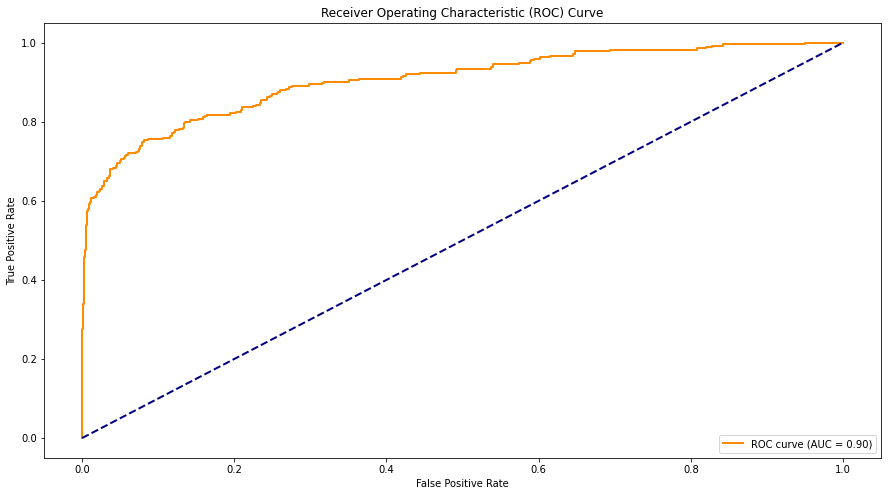

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Матрица ошибок

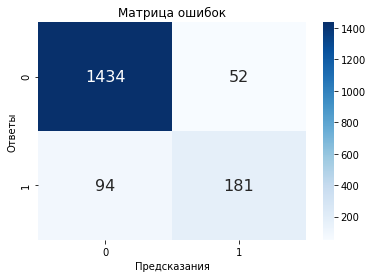

In [91]:
threshold = 0.5
y_pred_binary = (y_pred_proba > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

plt.xlabel("Предсказания")
plt.ylabel("Ответы")
plt.title("Матрица ошибок")

plt.show()

---

На основе данной матрицы ошибок и значения метрики ROC-AUC можно выделить следующие ключевые аспекты:

Значение ROC-AUC равное 0.9048 указывает на высокое качество модели. Чем ближе это значение к 1, тем лучше модель различает между положительными и отрицательными случаями на тестовой выборке.

То, что значение ROC-AUC на тестовой выборке близко к значению на тренировочной выборке, может свидетельствовать о хорошей обобщающей способности модели.

Относительно высокая чувствительность указывает на то, что модель хорошо выявляет положительные случаи. Высокое значение True Positive (TP) (181) в сочетании с низким False Negative (FN) (94) говорит о том, что модель относительно хорошо выявляет действительно положительные случаи.

Высокая специфичность указывает на то, что модель хорошо различает отрицательные случаи. Высокое значение True Negative (TN) (1434) в сочетании с низким False Positive (FP) (52) свидетельствует о том, что модель относительно хорошо предсказывает действительно отрицательные случаи.

Такие высокие значения TP и TN в сочетании с низкими значениями FN и FP подтверждают общую эффективность модели на тестовой выборке.

---

## Иследование важности признаков лучшей модели

---

Важность признаков будем смотреть на графиках SHAP

---

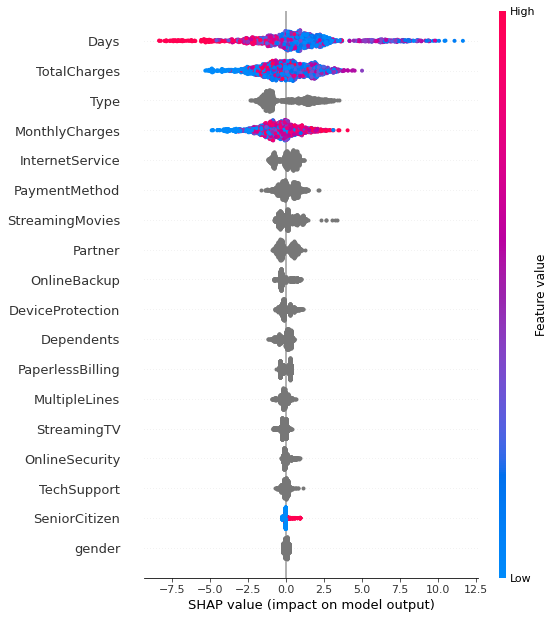

In [93]:
explainer = shap.Explainer(best_catboost_model)

shap_values = explainer.shap_values(x_test_not_cod)

shap.summary_plot(shap_values, x_test_not_cod, feature_names=x_test_not_cod.columns)

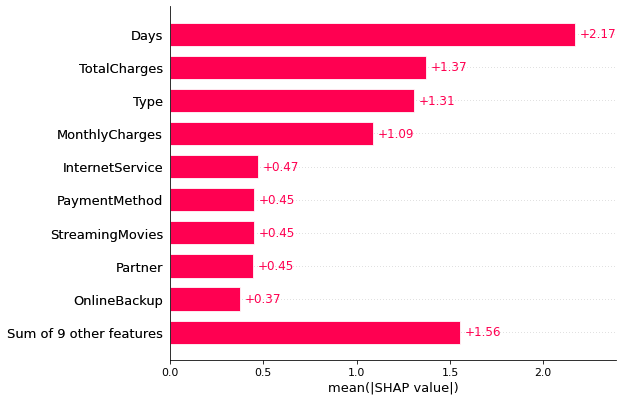

In [94]:
shap_values_explanation = shap.Explanation(shap_values, feature_names=x_test_not_cod.columns)

shap.plots.bar(shap_values_explanation)



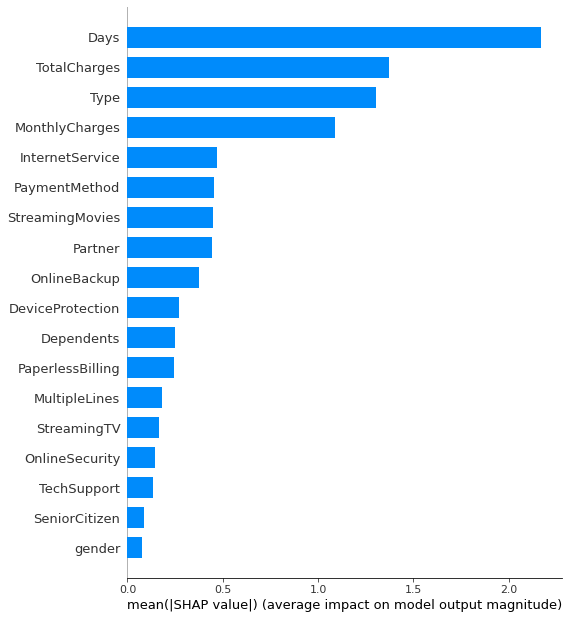

In [95]:
shap.summary_plot(shap_values, x_test_not_cod, feature_names=x_test_not_cod.columns, plot_type="bar")

---

Исходя из анализа графиков SHAP, можно выделить ключевые факторы, влияющие на целевой признак:

Days (Количество дней обслуживания): Этот признак оказывает наибольшее влияние. Как видно из первого графика, увеличение значения признака связано с уменьшением вероятности оттока. Это объяснимо тем, что клиенты, долго пользующиеся услугами, склонны оставаться.

TotalCharges (Общие расходы абонента): Этот признак также существенно влияет на модель. Большие общие расходы абонента связаны с меньшей вероятностью оттока.

Type (Тип оплаты): Вид оплаты также оказывает значительное влияние.

MonthlyCharges (Расходы за месяц): Этот параметр тоже имеет важное значение. Более низкие ежемесячные расходы связаны с меньшей вероятностью ухода клиента.

StreamingTV, OnlineSecurity, TechSupport, SeniorCitizen и Gender: Эти признаки оказывают наименьшее влияние. Вероятно, они имеют менее существенное воздействие на решение клиента об уходе.

Итак, проведенный анализ позволяет выделить ключевые факторы, оказывающие влияние на отток клиентов, что может быть использовано для разработки стратегий удержания.

---

# Вывод:

----

## Итоговая модель

---
На основе метрики ROC-AUC были рассмотрены все модели и выбрана наилучшая. Показатели метрик ROC-AUC рассмотренных моделей:

Базовая модель: 0.5

ROC-AUC представляет собой график зависимости доли верных положительных ответов (True Positive Rate) от доли ложных положительных ответов (False Positive Rate) при варьировании порога классификации. Значение ROC-AUC находится в диапазоне от 0 до 1, где 0.5 соответствует случайному классификатору, а 1 - идеальному. В вашем случае, базовая модель, всегда предсказывающая 0, демонстрирует ROC-AUC равный 0.5. Это объясняется следующим образом: True Positive Rate (TPR): Эта модель правильно идентифицирует все нулевые значения, поскольку она всегда предсказывает 0. Таким образом, TPR равен 1. False Positive Rate (FPR): Так как модель не делает ни одного положительного предсказания (всегда предсказывает 0), FPR также равен 0. Таким образом, кривая ROC в этом случае проходит через верхний левый угол графика, и площадь под ней, то есть ROC-AUC, оказывается равной 0.5.

Логистическая регрессия: 0.773

LogisticRegressionCV c обратной силой регуляризации Cv равной 1 не соответствует установленным требованиям, показав ROC-AUC равный 0.773. 

CatBoost: 0.926

Модель CatBoostClassifier с подобранными лучшими гиперпараметрами: 'depth': 2, 'learning_rate': 1 продемонстрировала лучшие результаты с ROC-AUC 0.926. Проведена проверка эффективности выбранной модели на тестовой выборке. Модель на тестовой выборке показала метрику ROC-AUC равную 0.905. Это указывает на высокое качество модели. Чем ближе это значение к 1, тем лучше модель различает между положительными и отрицательными случаями на тестовой выборке. Так как значение ROC-AUC на тестовой выборке достаточно близко к значению на тренировочной выборке, то это может свидетельствовать о хорошей обобщающей способности модели.

LightGBM: 0.89

Модель LGBMClassifier проявила отличные характеристики с оптимальными гиперпараметрами 'depth': 2 и 'learning_rate': 1, что привело к значению ROC-AUC на уровне 0.89. Тем не менее, несмотря на высокие показатели, решено было отдать предпочтение другой модели, поскольку LightGBM не продемонстрировал наивысшую эффективность в данной задаче.

---

## Выполнение шагов. Трудности и их решение. Ключевые этапы в решении.

---

В исходном этапе проекта все имеющиеся датасеты были собраны в общий датафрейм df. Важно отметить, что на этапе объединения не проводилась предварительная обработка данных. Это решение принято с учетом стремления избежать избыточной работы и повторного анализа данных.

В свою очередь, в объединенном датасете была проведена системная предобработка данных, включающая следующие этапы:

+ изменение типов данных с object на float64 у признака TotalCharges. Некоторые значения признака содержали пробелы, они были удалены, из-за чего на их месте возникли пропуски. Пропуски этого признака были заполнены произведением траты клиента за месяц на количество месяцев, в теение которых клиент пользуется услугами компании
+ Пропуски в признаках InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines были заменены на 'No', так как эти пропуски означают, что клиент не пользуется данной услугой.
+ Была произведена проверка на аномалии и дубликаты, которых не оказалось, из чего можно сделать вывод, что предоставленные данные чистые
+ Как и предполагалось ранее был создан новый признак Days, отражающий продолжительность сотрудничества клиента с компанией в днях.
+ Был создан целевой признак, отражающий уход клиента из компании, он был создан на основе признака EndDate. Если указанная дата - '2020-02-01', которая является датой актуальности данной базы данных, то это свидетельствует о том, что клиент продолжал пользоваться услугами до этого периода. Этих клиентов мы помечаем значением 0. Если дата отличается, это означает, что данный клиент прекратил пользоваться услугами, и таких клиентов мы помечаем значением 1.
+ Была рассмотрена матрица корреляций признаков объединенного датасета.
+ Для предотвращения мультиколлинеарности и избежания бесполезных данных в контексте машинного обучения были удалены следующие признаки: BeginDate, EndDate, customerID и созданный ранее для заполнения пропусков MonthDifference
+ Было замечено, что признаки InternetService, StreamingTV, StreamingMovies имеют высокий коэффициент корреляции с признаком MonthlyCharges. Но после некоторых проверок, которые не вошли в итоговую работу, обнаружено, что удаление этих признаков ухудшают метрику ROC-AUC

Данные разделены на тренировочную и тестовую выборки. 

Дополнительно рассматривается базовая модель, которая предсказывает на всех случаях 0.

Как и предполагалось ранее, были выбраны модели градиентного бустинга (CatBoost и LightGBM) и линейная модель (логистическая регрессия). Обучение проведено на тренировочных данных с помощью кросс-валидации с подбором лучших гиперпараметров. Для логистической регрессии была выбрана модель LogisticRegressionCV из библиотеки scikit-learn. Этот класс представляет собой логистическую регрессию с встроенной кросс-валидацией для подбора гиперпараметра регуляризации. Для моделей градиентных бустингов был использован GridSearchCV. Для логистиеской регрессии дополнительно было произведено кодирование OHE и масштабирование некоторых признаков.

---

## Матрица ошибок

---

[[1434 52]

 [94 181]]

+ True Positive (TP): 181 - Количество истинно положительных предсказаний.
+ True Negative (TN): 1434 - Количество истинно отрицательных предсказаний.
+ False Positive (FP): 52 - Количество ложно положительных предсказаний.
+ False Negative (FN): 94 - Количество ложно отрицательных предсказаний.

Модель правильно классифицировала 1434 отрицательных случая.
Для положительных случаев модель совершила 94 ошибки, предсказав их как отрицательные (ложно отрицательные).
Имеется 52 случая, когда модель ошибочно предсказала положительный класс (ложно положительные).
Верно предсказано 181 положительное наблюдение.

Модель показывает высокую чувствительность и специфичность, а ROC-AUC 0.905 подтверждает её качество.

---

## Список признаков, используемых для обучения лучшей модели

---

Произведен анализ важности признаков, представленных в порядке убывания значимости:

1. Days (Продолжительность сотрудничества клиента)

Признак, выражающий количество дней, в течение которых клиент использует услуги компании. Создан из разницы между признаками EndDate и BeginDate. Обладает наивысшей важностью, как подтверждено графиками SHAP. Из них видно, что чем больше клиент задействован в услугах, тем ниже вероятность расторжения контракта.

2. TotalCharges (Общие расходы абонента)

Признак, отражающий суммарные затраты абонента. Наблюдается тенденция: клиенты с более высокими расходами склонны к расторжению контракта.

3. Type (Тип оплаты)

Тип оплаты, включающий в себя разовые и ежегодные варианты. Имеет существенное воздействие, хотя, поскольку признак не является бинарным, а имеет три уникальных значения, визуализация не позволяет точно выделить, какие значения влияют на решение об уходе клиента.

4. MonthlyCharges (Расходы за месяц)

Признак, отражающий ежемесячные расходы. График подтверждает, что более высокие расходы в месяц связаны с увеличением вероятности расторжения контракта.

Остальные признаки:

+ InternetService (Тип подключения)
+ PaymentMethod (Способ оплаты)
+ StreamingMovies (Каталог фильмов)
+ Partner (Наличие супруга или супруги)
+ OnlineBackup (Облачное хранилище для резервного копирования данных)
+ DeviceProtection (Антивирус)
+ Dependents (Наличие детей)
+ PaperlessBilling (Электронный расчётный лист)

Имеют менее выраженное влияние на модель. Из графиков неочевидно, какие конкретные значения могут влиять на решение об уходе клиентов, из-за наличия более чем двух уникальных значений у этих признаков. .

+ MultipleLines (Подключение телефона к нескольким линиям)
+ StreamingTV (Стриминговое телевидение)
+ OnlineSecurity (Блокировка опасных сайтов)
+ TechSupport (Выделенная линия технической поддержки)
+ SeniorCitizen (Пенсионер)
+ Gender (Пол)

Обладают наименьшей важностью, хотя признак SeniorCitizen позволяет выделить, что пенсионеры более склонны к прекращению пользования услугами.

---